## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [27]:
# 1: creating Pandas DataFrame

filename = "data_000637.txt"
data = pd.read_csv(filename)
data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310720 entries, 0 to 1310719
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   HEAD         1310720 non-null  int64
 1   FPGA         1310720 non-null  int64
 2   TDC_CHANNEL  1310720 non-null  int64
 3   ORBIT_CNT    1310720 non-null  int64
 4   BX_COUNTER   1310720 non-null  int64
 5   TDC_MEAS     1310720 non-null  int64
dtypes: int64(6)
memory usage: 60.0 MB


In [30]:
# 2: finding out the number of BX_COUNTER in a ORBIT_CNT (x)

# a unit of BX_COUNTER corresponds to 25 ns
# the ORBIT_CNT is increased every x BX_COUNTER

data2 = data.groupby('ORBIT_CNT')
x = data2['BX_COUNTER'].max().max()-data2['BX_COUNTER'].min().min()+1 # we have to add 1 because bx_counter starts from 0 included
print('BX_COUNTER in a ORBIT_CNT:', x)

# otherwise simply data['BX_COUNTER'].max()+1

BX_COUNTER in a ORBIT_CNT: 3564


In [31]:
# 3: finding how much data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

n_orbits = data2.ngroups # how much groups we have in a grouped by df = number of orbits (to avoid probable missing values in orbits)
tot_measurement_time = x*25*n_orbits*10**(-9) # in seconds
print(f"Data taking lasted {tot_measurement_time:.3f} s.")

Data taking lasted 0.980 s.


In [13]:
# 4: creating a new column for absolute time in ns

data['TIME_NS'] = data['ORBIT_CNT']*x*25 + data['BX_COUNTER']*25 + data['TDC_MEAS']*25/30

data['TIME_NS'] = data['TIME_NS']-data['TIME_NS'].min() # to obtain absolute value (from start of data taking)

data.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.0000
1,1,0,124,3869200167,2374,27,0.8125
2,1,0,63,3869200167,2553,28,4476.6250
3,1,0,64,3869200167,2558,19,4594.1250
4,1,0,64,3869200167,2760,25,9649.1250


In [14]:
# 5: replacing randomly HEAD values with 0 or 1

data5 = data.copy()

data5['HEAD'] = np.random.randint(0,2, size=data.shape[0])

data5.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.0000
1,1,0,124,3869200167,2374,27,0.8125
2,1,0,63,3869200167,2553,28,4476.6250
3,1,0,64,3869200167,2558,19,4594.1250
4,1,0,64,3869200167,2760,25,9649.1250


In [15]:
# 6: creating a new dataframe that contains only the row with HEAD == 1

data6 = data[data['HEAD']==1]

data6.head()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.0000
1,1,0,124,3869200167,2374,27,0.8125
2,1,0,63,3869200167,2553,28,4476.6250
3,1,0,64,3869200167,2558,19,4594.1250
4,1,0,64,3869200167,2760,25,9649.1250


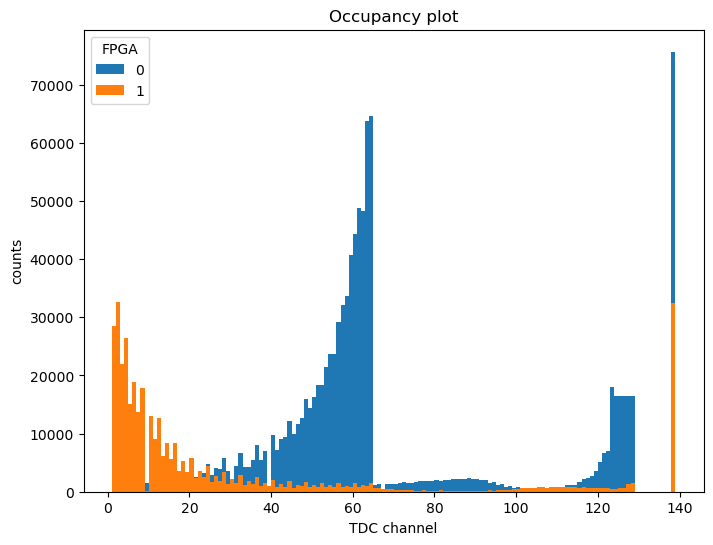

In [32]:
# 7: occupancy plots (one for each FPGA) = number of counts per TDC CHANNEL

data_fpga0 = data[data['FPGA']==0]
data_fpga1 = data[data['FPGA']==1]

counts0 = data_fpga0.groupby('TDC_CHANNEL').size()
counts1 = data_fpga1.groupby('TDC_CHANNEL').size()

fig, ax = plt.subplots(figsize = (8,6))

ax.hist(x = counts0.index, bins=counts0.index, weights=counts0.values, label = '0')
ax.hist(x = counts1.index, bins=counts1.index, weights=counts1.values, label = '1')
ax.legend(title='FPGA')
ax.set_xlabel('TDC channel')
ax.set_ylabel('counts')
ax.set_title('Occupancy plot')
plt.show()

In [20]:
# 8: Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

counts0.sort_values(ascending=False)

TDC_CHANNEL
139    75617
64     64581
63     63724
61     48699
62     48275
       ...  
130       33
137       32
30         4
129        2
39         1
Length: 124, dtype: int64

In [18]:
counts1.sort_values(ascending=False)

TDC_CHANNEL
2      32669
139    32442
1      28438
4      26403
3      21970
       ...  
9         80
130       38
137       36
138       36
129       35
Length: 132, dtype: int64

In [21]:
# 9: counting the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

data['ORBIT_CNT'].unique().shape[0] # number of unique orbits

11001

In [22]:
# Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
data9 = data[data['TDC_CHANNEL'] == 139]
data9['ORBIT_CNT'].unique().shape[0]

10976